<a href="https://colab.research.google.com/github/nikizadehgfdl/thin-wall-topography/blob/dev/python/algorithm_dev-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook is for developement and testing of algorithm for the thin wall topography

## GridMesh Class

In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


class GMesh:
    """Describes 2D meshes for ESMs.
    
    Meshes have shape=(nj,ni) cells with (nj+1,ni+1) vertices with coordinates (x,y).
    
    When constructing, either provide 1d or 2d coordinates (x,y), or assume a
    uniform spherical grid with 'shape' cells covering the whole sphere with
    longitudes starting at x0.
    
    Attributes:
    
    shape - (nj,ni)
    ni    - number of cells in x-direction (last)
    nj    - number of cells in y-direction (first)
    x     - longitude of mesh (cell corners), shape (nj+1,ni=1)
    y     - latitude of mesh (cell corners), shape (nj+1,ni=1)
    area  - area of cells, shape (nj,ni)
    """

    def __init__(self, shape=None, x=None, y=None, area=None, x0=-180., rfl=0):
        """Constructor for Mesh:
        shape - shape of cell array, (nj,ni)
        ni    - number of cells in x-direction (last index)
        nj    - number of cells in y-direction (first index)
        x     - longitude of mesh (cell corners) (1d or 2d)
        y     - latitude of mesh (cell corners) (1d or 2d)
        area  - area of cells (2d)
        x0    - used when generating a spherical grid in absence of (x,y)
        rfl   - refining level of this mesh
        """
        if (shape is None) and (x is None) and (y is None): raise Exception('Either shape must be specified or both x and y')
        if (x is None) and (y is not None): raise Exception('Either shape must be specified or both x and y')
        if (x is not None) and (y is None): raise Exception('Either shape must be specified or both x and y')
        # Determine shape
        if shape is not None:
            (nj,ni) = shape
        else: # Determine shape from x and y
            if (x is None) or (y is None): raise Exception('Either shape must be specified or both x and y')
            if len(x.shape)==1: ni = x.shape[0]-1
            elif len(x.shape)==2: ni = x.shape[1]-1
            else: raise Exception('x must be 1D or 2D.')
            if len(y.shape)==1 or len(y.shape)==2: nj = y.shape[0]-1
            else: raise Exception('y must be 1D or 2D.')
        self.ni = ni
        self.nj = nj
        self.shape = (nj,ni)
        # Check shape of arrays and construct 2d coordinates
        if x is not None and y is not None:
            if len(x.shape)==1:
                if len(y.shape)>1: raise Exception('x and y must either be both 1d or both 2d')
                if x.shape[0] != ni+1: raise Exception('x has the wrong length')
            if len(y.shape)==1:
                if len(x.shape)>1: raise Exception('x and y must either be both 1d or both 2d')
                if y.shape[0] != nj+1: raise Exception('y has the wrong length')
            if len(x.shape)==2 and len(y.shape)==2:
                if x.shape != y.shape: raise Exception('x and y are 2d and must be the same size')
                if x.shape != (nj+1,ni+1): raise Exception('x has the wrong size')
                self.x = x
                self.y = y
            else:
                self.x, self.y = np.meshgrid(x,y)
        else: # Construct coordinates
            y1d = np.linspace(-90.,90.,nj+1)
            x1d = np.linspace(x0,x0+360.,ni+1)
            self.x, self.y = np.meshgrid(x1d,y1d)
        if area is not None:
            if area.shape != (nj,ni): raise Exception('area has the wrong shape or size')
            self.area = area
        else:
            self.area = None
        
        self.rfl = rfl #refining level

    def __repr__(self):
        return '<GMesh ni:%i nj:%i shape:(%i,%i)>'%(self.ni,self.nj,self.shape[0],self.shape[1])
    def __getitem__(self, key):
        return getattr(self, key)

    def dump(self):
        print(self)
        print('x.rfl   =',self.rfl)
        print('x.shape =',self.x.shape)
        print('y.shape =',self.y.shape)
        print('h.shape =',self.height.shape)

    def refineby2(self):
        """Returns new Mesh instance with twice the resolution"""
        x = np.zeros( (2*self.nj+1, 2*self.ni+1) )
        y = np.zeros( (2*self.nj+1, 2*self.ni+1) )
        #area = numpy.zeros( (2*self.nj, 2*self.ni) )
        x[::2,::2] = self.x
        x[::2,1::2] = 0.5 * ( self.x[:,:-1] + self.x[:,1:] )
        x[1::2,::2] = 0.5 * ( self.x[:-1,:] + self.x[1:,:] )
        x[1::2,1::2] = 0.25 * ( ( self.x[:-1,:-1] + self.x[1:,1:] ) + ( self.x[:-1,1:] + self.x[1:,:-1] ) )
        y[::2,::2] = self.y
        y[::2,1::2] = 0.5 * ( self.y[:,:-1] + self.y[:,1:] )
        y[1::2,::2] = 0.5 * ( self.y[:-1,:] + self.y[1:,:] )
        y[1::2,1::2] = 0.25 * ( ( self.y[:-1,:-1] + self.y[1:,1:] ) + ( self.y[:-1,1:] + self.y[1:,:-1] ) )
        return GMesh(x=x, y=y, rfl=self.rfl+1)
        
    def coarsenby2(self, coarser_mesh):
        """Set the height for lower level Mesh by coarsening"""
        if(self.rfl == 0): 
            raise Exception('Coarsest grid, no more coarsening possible!')
 
        coarser_mesh.height = self.height[::2,::2]
#        coarser_mesh.height[:-1,:-1] = 0.5*(coarser_mesh.height[:-1,:-1]+self.height[1::2,1::2])
        coarser_mesh.height[:-1,:-1] = 0.25*(coarser_mesh.height[:-1,:-1]
                                            + self.height[1::2,1::2]
                                            + self.height[1:-1:2,0:-1:2]
                                            + self.height[0:-1:2,1:-1:2])


    def find_nn_uniform_source(self,xs,ys):
        """Returns the i&j arrays for the indexes of the nearest neighbor point to each mesh point"""
        #Here we assume that the source mesh {(xs,ys)} is a uniform lat-lon mesh!
        #In this case the index of the closest source point can be easily found by arithmetic.          
        if (not is_source_uniform(xs,ys)): raise Exception('source grid is not uniform, this method will not work properly')
        delxs = xs[0,1] - xs[0,0]
        delys = ys[1,0] - ys[0,0]        
#        nn_i = np.rint((self.x-xs[0,0])/delxs) #Nearest integer (the even one if equidistant)
#        nn_j = np.rint((self.y-ys[0,0])/delys)   
        nn_i = np.floor(0.5+(self.x-xs[0,0])/delxs) #Nearest integer (the upper one if equidistant)
        nn_j = np.floor(0.5+(self.y-ys[0,0])/delys)  
        #These must be bounded by the extents of the arrays
        upper_i=xs.shape[1]-1
        upper_j=ys.shape[0]-1
        nn_i = np.where(nn_i>upper_i, upper_i, nn_i)
        nn_j = np.where(nn_j>upper_j, upper_j, nn_j)
        nn_i = np.where(nn_i<0, 0, nn_i)
        nn_j = np.where(nn_j<0, 0, nn_j)
        return nn_i.astype(int),nn_j.astype(int)
    
    def source_hits(self, xs, ys):
        """Returns the number of times each source data point is sampled by this mesh"""
        #This depends on the sampling method
        #Here we assume a Nearest Neighbor sampling. 
        #For each GMesh point (x,y):
        #   find the nearest point on the source mesh {(xs,ys)}
        #   increment the number of hits for that source point
        #
        if xs.shape != ys.shape: raise Exception('xs and ys must be the same shape')
        nns_i,nns_j = self.find_nn_uniform_source(xs,ys) 
        hits = np.zeros(xs.shape)
        hits[nns_j[:,:],nns_i[:,:]] = 1
#Niki: Deal with the degenerate cases where source points are well outside the target domain 
#      and are never going to be hit.
        return hits

    def project_source_data_onto_target_mesh(self,xs,ys,zs):
        """Returns the array on target mesh with values equal to the nearest-neighbor source point data"""
        if xs.shape != ys.shape: raise Exception('xs and ys must be the same shape')
        nns_i,nns_j = self.find_nn_uniform_source(xs,ys) 
        self.height = np.zeros(self.x.shape)
        self.height[:,:] = zs[nns_j[:,:],nns_i[:,:]]
        return 

#################
#Helper functions
#################

def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r',alpha=1.0):
    #mesh plot
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color, alpha=alpha)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color, alpha=alpha)

def generate_rect_test_grid(lons,lone,ni,lats,late,nj):
    #generate a simple rectilinear grid
    lon = lons + np.arange(ni+1) * (lone-lons)/ni
    lat = lats + np.arange(nj+1) * (late-lats)/nj
    lon_grid = np.tile(lon, (nj+1,1)) 
    lat_grid = np.tile(lat.reshape(nj+1,1), (1,ni+1))
    return lon_grid,lat_grid


def is_source_uniform(xs,ys):
    """Returns True if the input grid is uniform and False otherwise"""
    delx = np.roll(xs,shift=-1, axis=1) - xs 
    delx = delx[:,:-1]
    dely = np.roll(ys,shift=-1, axis=0) - ys 
    dely = dely[:-1,:]
    return (np.all(np.isclose(delx, delx[0,0]))) and (np.all(np.isclose(dely, dely[0,0])))

def refine_loop(trg_lon_grid,trg_lat_grid, src_lon_grid,src_lat_grid, max_stages=5):
    """This function refines the target grid until all points in the source grid are sampled."""
    """It returns the list of the refined grids."""
    GMesh_list = []    
    GMesh_list.append(GMesh(x=trg_lon_grid,y=trg_lat_grid))
    i=0
    hits = GMesh_list[i].source_hits(src_lon_grid,src_lat_grid)
    while(not np.all(hits) and i <= max_stages):
        print("Missed some! Must Refine! Stage ", i+1, "grid shape", GMesh_list[i].x.shape)
        GMesh_list.append(GMesh_list[i].refineby2())
        i=i+1
        hits = GMesh_list[i].source_hits(src_lon_grid,src_lat_grid)
        
    if(i > max_stages): 
        print("Warning: Maximum number of allowed refinements reached without all source points hit.")
    else:        
        print("Hit all! Done refining after ",i, " steps!")
        
    return GMesh_list, hits 


def get_indices0(lon_grid,lat_grid,x,y):
    lons=np.fabs(lon_grid-x)
    lonm=np.where(lons==lons.min())
    lats=np.fabs(lat_grid-y)
    latm=np.where(lats==lats.min())
    j0=latm[0][0]
    i0=lonm[1][0]
    print("wanted: ",x,y)
    print("got:    ",lon_grid[j0,i0] , lat_grid[j0,i0])
    print(j0,i0)
    return j0,i0

def get_indices(lon_grid,lat_grid,x,y):
    """This function returns the j,i indices for the grid point closest to the input lon,lat coordinates."""
    """It returns the j,i indices."""
    lons=np.fabs(lon_grid-x)
    lonm=np.where(lons==lons.min())
    lats=np.fabs(lat_grid-y)
    latm=np.where(lats==lats.min())
    j0=latm[0][0]
    i0=lonm[1][0]
    print("wanted: ",x,y)
    print("got:    ",lon_grid[j0,i0] , lat_grid[j0,i0])
    print(j0,i0)
    return j0,i0

#Gibraltar
#wanted:  32.0 -12.5
#got:     31.9958333333 -12.5041666667
#9299 25439
#Gibraltar
#wanted:  40.7 4.7
#got:     40.6958333333 4.69583333333
#11363 26483
#Black sea
#wanted:  44.0 36
#got:     43.9958333333 36.0041666667
#15120 26879


def block_array(a,xb=2,yb=2):
    if(xb != 2 or yb !=2): raise Exception('This rotuine can only make 2x2 blocks!')
        ##Niki: Implement a better algo and lift this restriction
    a_win = []
    i1 = a.shape[1]//xb
    i2 = a.shape[1]
    j1 = a.shape[0]//yb
    j2 = a.shape[0]
    a_win.append(a[0:j1,0:i1])
    a_win.append(a[0:j1,i1:i2])
    a_win.append(a[j1:j2,0:i1])
    a_win.append(a[j1:j2,i1:i2])
    return a_win



def write_topo_nc(depth,std, fnam=None,format='NETCDF3_CLASSIC'):
    import netCDF4 as nc

    if fnam is None:
      fnam='topog_.nc'
    f=nc.Dataset(fnam,'w',format=format)

    nytot,nxtot = depth.shape
    ny=f.createDimension('ny',nytot)
    nx=f.createDimension('nx',nxtot)
    f.createDimension('ntiles',1)
    
    meanv=f.createVariable('depth','f8',('ny','nx'))
    meanv.units='meters'
    meanv.standard_name='topographic depth at T-cell centers'
    meanv[:]=depth

    stdv=f.createVariable('std','f8',('ny','nx'))
    stdv.units='meters'
    stdv[:]=std
    
    f.sync()
    f.close()


In [2]:
#import inspect
#import imp  
#import GMesh as gm

#Reload the GMesh tool (in case you change something in the tool and want it to take effect in this notebook)
#imp.reload(gm) 

#gm_source = inspect.getsource(gm)
#print(gm_source)

#refinedGMlist, hits = gm.refine_loop(trg_lon_grid,trg_lat_grid, src_lon_grid,src_lat_grid)
#refinedGMlist[-1].dump()

## Read the target grid

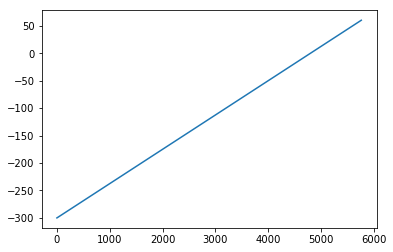

In [3]:
#Read in Mercator grid for 1/8 degree model
Merc_p125_grid =  netCDF4.Dataset('/net2/nnz/grid_generation/workdir/grid_OM4p125_new/tripolar_disp_res8.ncMerc.nc')
Merc_p125_lon = np.array(Merc_p125_grid.variables['x'])
Merc_p125_lat = np.array(Merc_p125_grid.variables['y'])
#print(Merc_p125_lon.shape,Merc_p125_lat.shape) #(2800, 5761) (2800, 5761)
#Make longitude between -180 and 180
#Merc_p125_lon = np.where(Merc_p125_lon<-180.0 , Merc_p125_lon+360, Merc_p125_lon)
plt.plot(Merc_p125_lon[0,:])

#Niki: Deal with the mismatch for starting longitude in source and target grids (-180 and -300 rsp)

## Read GEBCO dataset for topography

In [4]:
#Global grid
#gebcodata = netCDF4.Dataset('/archive/gold/datasets/topography/GEBCO_08_v1.nc')
gebcodata = netCDF4.Dataset('/net2/nnz/thin-wall-topography/python/workdir/GEBCO_2014_2D.nc')
#gebcodata
#for var in gebcodata.variables :  print(var,end=' ') # elevation lat lon    
#Note that the variables are arrays but they are not numpy arrays. 
#Convert them to numpy using np.array so that they can be reshaped.
gebco_lon = np.array(gebcodata.variables['lon'])
gebco_lat = np.array(gebcodata.variables['lat'])
gebco_elv = np.array(gebcodata.variables['elevation'])
print('source grid array shapes: ' , gebco_lon.shape,gebco_lat.shape,gebco_elv.shape)
#source grid array shapes:  (43200,) (21600,) (21600, 43200)

source grid array shapes:  (43200,) (21600,) (21600, 43200)


In [5]:
#gebco_lon_grd = np.tile(gebco_lon,(gebco_lat.shape[0],1))
#gebco_lat_grd = np.tile(gebco_lat.reshape(gebco_lat.shape[0],1),(1,gebco_lon.shape[0]))
#print(gebco_lon_grd.shape,gebco_lat_grd.shape)
##(21600, 43200) (21600, 43200)
#plt.figure(figsize=(10,10))
#plt.pcolormesh(gebco_lon_grd[::100,::100], gebco_lat_grd[::100,::100],gebco_elv[::100,::100]);plt.colorbar();


## Shift the source grid longitude to match our model grid longitude

The ocean model grids that we use all start at -300 degrees whereas the GEBCO dataset starts at -180 degrees. In the following we map the source grid to match our model grid choice.

    Could someone please check the following logic! 

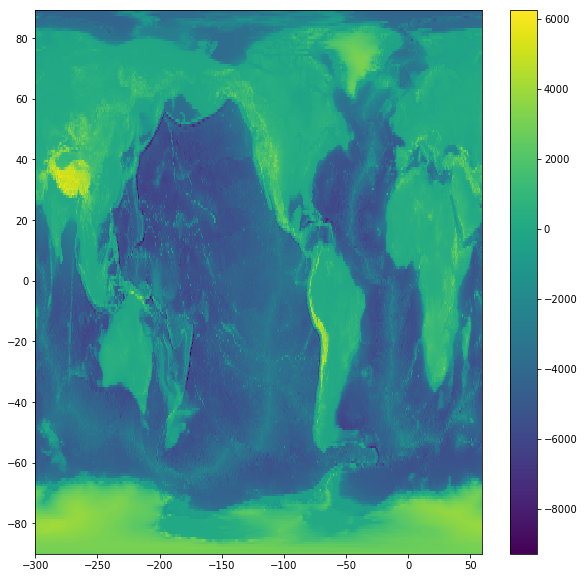

In [6]:
gebco_lon2 = np.roll(gebco_lon,14400,axis=0) #Roll GEBCO longitude to right. 14400 was a lucky guess that checked out!
gebco_lon2 = np.where(gebco_lon2>60 , gebco_lon2-360, gebco_lon2) #Rename (0,60) as (-300,-180) 
gebco_elv2 = np.roll(gebco_elv,14400,axis=1) #Roll GEBCO depth to the right by the same amount.
gebco_lon_grd = np.tile(gebco_lon2,(gebco_lat.shape[0],1))
gebco_lat_grd = np.tile(gebco_lat.reshape(gebco_lat.shape[0],1),(1,gebco_lon2.shape[0]))
plt.figure(figsize=(10,10))
plt.pcolormesh(gebco_lon_grd[::100,::100], gebco_lat_grd[::100,::100],gebco_elv2[::100,::100]);plt.colorbar();


## Divide the Target grid into blocks
 The 1/8 degree grid is too big to be handled in one go (my 64G machine runs out of memory and starts  to swap rendering the machine useless). Hence, we break the target to pieces and handle them one at a time. 

Future enhancement: 

    Make the block shape arbitrary rather than 2x2
    Delegate these blocks to GPU tasks.

In [7]:
#Break the target grid into 4 blocks    
Merc_p125_lon_blk = block_array(Merc_p125_lon,2,2)    

print(Merc_p125_lon_blk[0][0,0],Merc_p125_lon_blk[0][0,-1])
print(Merc_p125_lon_blk[1][0,0],Merc_p125_lon_blk[1][0,-1])
print(Merc_p125_lon_blk[2][0,0],Merc_p125_lon_blk[2][0,-1])
print(Merc_p125_lon_blk[3][0,0],Merc_p125_lon_blk[3][0,-1])

Merc_p125_lat_blk = block_array(Merc_p125_lat,2,2)    

print(Merc_p125_lat_blk[0][0,0],Merc_p125_lat_blk[0][-1,0])
print(Merc_p125_lat_blk[1][0,0],Merc_p125_lat_blk[1][-1,0])
print(Merc_p125_lat_blk[2][0,0],Merc_p125_lat_blk[2][-1,0])
print(Merc_p125_lat_blk[3][0,0],Merc_p125_lat_blk[3][-1,0])

-300.0 -120.0625
-120.0 60.0
-300.0 -120.0625
-120.0 60.0
-66.8840965847 -3.49782528316
-66.8840965847 -3.49782528316
-3.43543964987 64.004225313
-3.43543964987 64.004225313


## Refine-Sample-Coarsen each block

In [23]:
def do_blocks(blk):

    #Get the block indices for the corresponding source grid
    jl,il = get_indices(gebco_lon_grd,gebco_lat_grd, Merc_p125_lon_blk[blk][0,0],  Merc_p125_lat_blk[blk][0,0] )
    ju,iu = get_indices(gebco_lon_grd,gebco_lat_grd, Merc_p125_lon_blk[blk][0,-1], Merc_p125_lat_blk[blk][-1,0])

    #Get the source data block
    gebco_ind_blk = np.index_exp[jl+1:ju-1,il+1:iu-1]   

    gebco_lon_blk=gebco_lon_grd[gebco_ind_blk]
    gebco_lat_blk=gebco_lat_grd[gebco_ind_blk]
    gebco_elv_blk=gebco_elv2[gebco_ind_blk]
    #print(gebco_lon_blk.shape,gebco_lat_blk.shape,gebco_elv_blk.shape)
    #plt.pcolormesh(gebco_lon_blk, gebco_lat_blk,gebco_elv_blk);plt.colorbar();

    refinedGMlist_p125, hits_p125 = refine_loop(Merc_p125_lon_blk[blk], Merc_p125_lat_blk[blk], gebco_lon_blk,gebco_lat_blk)

    refinedGMlist_p125[-1].project_source_data_onto_target_mesh(gebco_lon_blk,gebco_lat_blk,gebco_elv_blk)
    refinedGMlist_p125[-1].dump()

    for i in reversed(range(1,len(refinedGMlist_p125))):   # 1, makes it stop at element 1 rather than 0
        refinedGMlist_p125[i].coarsenby2(refinedGMlist_p125[i-1])
        refinedGMlist_p125[i-1].dump()

    return refinedGMlist_p125[0].x,refinedGMlist_p125[0].y,refinedGMlist_p125[0].height
    
        
gx=[]    
gy=[]
gh=[]
for blk in range(4):
    ggx,ggy,ggh = do_blocks(blk)
    gx.append(ggx)
    gy.append(ggy)
    gh.append(ggh)
    
#return the memory
#ggx=None
#ggy=None
#ggh=None

    

wanted:  -300.0 -66.8840965847
got:     -299.995833333 -66.8875
2773 0
wanted:  -120.0625 -3.49782528316
got:     -120.0625 -3.49583333333
10380 21592
Missed some! Must Refine! Stage  1 grid shape (1400, 2880)
Missed some! Must Refine! Stage  2 grid shape (2799, 5759)
Missed some! Must Refine! Stage  3 grid shape (5597, 11517)
Hit all! Done refining after  3  steps!
<GMesh ni:23032 nj:11192 shape:(11192,23032)>
x.rfl   = 3
x.shape = (11193, 23033)
y.shape = (11193, 23033)
h.shape = (11193, 23033)
<GMesh ni:11516 nj:5596 shape:(5596,11516)>
x.rfl   = 2
x.shape = (5597, 11517)
y.shape = (5597, 11517)
h.shape = (5597, 11517)
<GMesh ni:5758 nj:2798 shape:(2798,5758)>
x.rfl   = 1
x.shape = (2799, 5759)
y.shape = (2799, 5759)
h.shape = (2799, 5759)
<GMesh ni:2879 nj:1399 shape:(1399,2879)>
x.rfl   = 0
x.shape = (1400, 2880)
y.shape = (1400, 2880)
h.shape = (1400, 2880)
wanted:  -120.0 -66.8840965847
got:     -119.995833333 -66.8875
2773 21600
wanted:  60.0 -3.49782528316
got:     59.99583333

In [24]:
gxS=np.concatenate((gx[0],gx[1]),axis=1)
gxN=np.concatenate((gx[2],gx[3]),axis=1)
gxG=np.concatenate((gxS,gxN),axis=0)
#plt.plot(gxG[0,:]);

gyS=np.concatenate((gy[0],gy[1]),axis=1)
gyN=np.concatenate((gy[2],gy[3]),axis=1)
gyG=np.concatenate((gyS,gyN),axis=0)
#plt.plot(gyG[:,0]);

ghS=np.concatenate((gh[0],gh[1]),axis=1)
ghN=np.concatenate((gh[2],gh[3]),axis=1)
ghG=np.concatenate((ghS,ghN),axis=0)

#write_topo_nc(ghG,ghG*0, fnam='/net2/nnz/thin-wall-topography/python/workdir/topog_Merc.nc')

#plt.figure(figsize=(15,8))
#plt.pcolormesh(gxG,gyG,ghG); plt.colorbar();  
